In [1]:
import argparse
import spacy
import unidecode
import re, string, unicodedata
import nltk
import contractions
import inflect
import pandas as pd
import numpy as np 
from nltk.corpus import wordnet as wn
from collections import Counter
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from bs4 import BeautifulSoup

from gensim.models import word2vec, FastText

from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import plotly.graph_objects as go

from wordcloud import WordCloud, STOPWORDS

nltk.download('punkt')
# load spacy model, can be "en_core_web_sm" as well
#nlp = spacy.load('en_core_web_md')

[nltk_data] Downloading package punkt to /Users/parisa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
import gensim.models
model = gensim.models.KeyedVectors.load_word2vec_format('/Users/parisa/Documents/MS_Research/Code/GoogleNews-vectors-negative300.bin', binary=True) 

### Define intersection between attackt example functions 

In [2]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3
   
def remove_brackets(sample_str):
    sample_str = sample_str.replace("[[", "")
    sample_str = sample_str.replace("]]", "")
    return sample_str

def clean_up_list(str_list):
    final_list=[]
    for item in str_list:
        final_list.append(remove_brackets(item))
    return final_list

def comparing(lst1, lst2):
    items = intersection(lst1, lst2)
    return len(items), items

# Generate a report from the imtersection between 2 different arracks
def intersection_report(failed_lst1, failed_lst2,succeeded_lst1, succeeded_lst2, attack1, attack2):
    
    f_intersect_num, f_intersect_items = comparing(failed_lst1, failed_lst2)
    print('Intersection number of failed examples between', attack1, 'and', attack2, sep=" ")
    print(f_intersect_num)
   
    s_intersect_num, s_intersect_items = comparing(succeeded_lst1, succeeded_lst2)
    print('Intersection number of succeeded examples between', attack1, 'and', attack2, sep=" ")
    print(s_intersect_num)
    
    return f_intersect_items, s_intersect_items

# Parse textattack results
def parse_text_file(filename):
    # Constant Variable
    divide_section_string = '--------------------------------------------- Result'
    # Initialize variable
    count = 0
    failed_examples = []
    succeeded_examples = []
    attack_examples = []
    # Read text file line by line
    f = open(filename, 'r')
    lines = f.readlines()
   
    pattern = re.compile(r'\[\[[0-9a-zA-Z\'\-]+\]\]')

    while count < len(lines):
        if divide_section_string in lines[count]: 
            count += 1
            if '[[[FAILED]]]' in lines[count] or '[[SKIPPED]]' in lines[count]:
                count += 2
                failed_examples.append(lines[count])
            else:
                count += 2
                succeeded_examples.append(lines[count])
                count += 2
                attack_examples.append(lines[count])
            count +=1
        count += 1       

    return failed_examples, succeeded_examples, attack_examples

### Text clean up functions

In [3]:
# to remove HTML tag
def html_remover(data):
  beauti = BeautifulSoup(data,'html.parser')
  return beauti.get_text()

# to remove URL
def url_remover(data):
  return re.sub(r'https\S','',data)

# Perform web clean up
def web_associated(data):
  text = html_remover(data)
  text = url_remover(text)
  return text

### Remove text noise functions

In [4]:
def remove_round_brackets(data):
  return re.sub('\(.*?\)','',data)

def remove_punc(data):
  trans = str.maketrans('','', string.punctuation)
  return data.translate(trans)

def white_space(data):
  return ' '.join(data.split())

# Perform all the function above to remove the noise from the text
def complete_noise(data):
  new_data = remove_round_brackets(data)
  new_data = remove_punc(new_data)
  new_data = white_space(new_data)
  return new_data

### Normalize the text

In [5]:
def text_lower(data):
  return data.lower()

def contraction_replace(data):
  return contractions.fix(data)

def remove_numbers(data):
  return ''.join([i for i in data if not i.isdigit()])

def normalization(data):
  text = text_lower(data)
  text = remove_numbers(text)
  text = contraction_replace(text)
  
  tokens = nltk.word_tokenize(text)
  return tokens


### Stemming and Lemmatiazation

In [6]:
def stopword(data):
  nltk.download('stopwords')
  clean = []
  for i in data:
    if i not in stopwords.words('english'):
      clean.append(i)
  return clean

def stemming(data):
  stemmer = LancasterStemmer()
  stemmed = []
  for i in data:
    stem = stemmer.stem(i)
    stemmed.append(stem)
  return stemmed

def lemmatization(data):
  nltk.download('wordnet')
  lemma = WordNetLemmatizer()
  lemmas = []
  for i in data:
    lem = lemma.lemmatize(i, pos='v')
    lemmas.append(lem)
  return lemmas  

def final_process(data):
  stopwords_remove = stopword(data)
  stemmed = stemming(stopwords_remove)
  lemm = lemmatization(stopwords_remove)
  return stemmed, lemm


### Preprocess the text using all the above functions

In [7]:
def preprocessing_text(text):
    # Process after removing URL and HTML tag
    new_data = web_associated(text)
    # Process after removing noisy space and charachter
    new_data = complete_noise(new_data)
    # Generate tokens with normalization
    tokens = normalization(new_data)
    # Process remove stopword, lemming and stemming
    stem,lemmas = final_process(tokens)
    return lemmas

In [8]:
# Preprocess all the examples
def preprocess_all_sentences(sentences):
    preprocess_sentences = []
    for item in sentences:
        preprocess_sentences.append(preprocessing_text(item))
    return preprocess_sentences

In [9]:
def extract_len_sen(sentences):
    len_list = []
    for item in sentences:
        len_list.append(len(item))
    return len_list

In [10]:
def print_mean_std(s,s1,s2, lst):
    print(s,'examples between',s1,'and', s2, 'mean and std:',np.mean(extract_len_sen(lst)), np.std(extract_len_sen(lst)),sep=" ")

In [11]:
def create_word_list(sentences):
    words = []
    for sentence in sentences:
        words = words + sentence
    return words

In [12]:
def create_word2vec_list(words):
    word2vec_list = []
    e_words = []
    for word in words:
        if word in model.vocab:
            word2vec_list.append(model[word])
            e_words.append(word)
    return word2vec_list, e_words

### Extract purturbed words from attack examples 

In [13]:
def intersection_with_index(lst1, lst2):
    new_lst = []
    index1 = []
    index2 = []
    no_insec_index1 = []
    no_insec_index2 = []
    for item in lst2:
        if item in lst1:
            new_lst.append(item)
            index1.append(lst1.index(item))
            index2.append(lst2.index(item))
        else:
            #no_insec_index1.append(lst1.index(item))
            no_insec_index2.append(lst2.index(item))
    
    for item in lst1:
        if item not in lst2:
            no_insec_index1.append(lst1.index(item))  
    
    return new_lst, index1, index2

def remove_bracket_square_word(word):
    word = word[2:len(word)-2]
    return word

def extract_purturb_words(lst, indexs):
    match_lst = []
    pattern = re.compile(r'\[\[[0-9a-zA-Z\'\-]+\]\]')
    for index in indexs:
        matches = pattern.findall(lst[index])
        match_lst.append([remove_bracket_square_word(word) for word in matches])
    return match_lst

In [15]:
def difference(lst1, lst2):
    lst3 = [value for value in lst1 if value not in lst2]
    return lst3

def extract_intesect_purturb_words(clean_s_examples1, clean_s_examples2, s_examples1, s_examples2, attack_examples1, attack_examples2):
    new_lst, index1, index2 = intersection_with_index(clean_s_examples1, clean_s_examples2)
    purturbed_words1 = extract_purturb_words(s_examples1, index1)
    purturbed_words2 = extract_purturb_words(s_examples2, index2)
    replaced_words1 = extract_purturb_words(attack_examples1, index1)
    replaced_words2 = extract_purturb_words(attack_examples2, index2)
    
    intersect_purturbed_words = []
    for i in range(len(purturbed_words1)):
        intersect_purturbed_words.append(intersection(purturbed_words1[i], purturbed_words2[i]))
    
    not_in_2 = []
    for i in range(len(purturbed_words1)):
        not_in_2.append(difference(purturbed_words1[i], purturbed_words2[i]))
    not_in_1 = []
    for i in range(len(purturbed_words1)):
        not_in_1.append(difference(purturbed_words2[i], purturbed_words1[i]))
        
    return intersect_purturbed_words, index1, index2, not_in_1, not_in_2

### Import ALBERT textattack results from performing different attack method

In [14]:
t_failed_examples, t_succeeded_examples, t_attack_examples = parse_text_file('textattack-logs/albert_textfooler')
d_failed_examples, d_succeeded_examples, d_attack_examples = parse_text_file('textattack-logs/albert_deepwordbug')
p_failed_examples, p_succeeded_examples, p_attack_examples = parse_text_file('textattack-logs/albert_pwws')
b_failed_examples, b_succeeded_examples, b_attack_examples = parse_text_file('textattack-logs/albert_bae')


t_400_failed_examples, t_400_succeeded_examples, t_400_attack_examples = parse_text_file('textattack-logs/400_textfooler_albert')
p_400_failed_examples, p_400_succeeded_examples, p_400_attack_examples = parse_text_file('textattack-logs/400_pwws_albert')
d_400_failed_examples, d_400_succeeded_examples, d_400_attack_examples = parse_text_file('textattack-logs/400_deepwordbug_albert')
b_400_failed_examples, b_400_succeeded_examples, b_400_attack_examples = parse_text_file('textattack-logs/400_bae_albert')


t_s = clean_up_list(t_succeeded_examples) + clean_up_list(t_400_succeeded_examples)
p_s = clean_up_list(p_succeeded_examples) + clean_up_list(p_400_succeeded_examples)
d_s = clean_up_list(d_succeeded_examples) + clean_up_list(d_400_succeeded_examples)
b_s = clean_up_list(b_succeeded_examples) + clean_up_list(b_400_succeeded_examples)

t_a = clean_up_list(t_attack_examples) + clean_up_list(t_400_attack_examples)
p_a = clean_up_list(p_attack_examples) + clean_up_list(p_400_attack_examples)
d_a = clean_up_list(d_attack_examples) + clean_up_list(d_400_attack_examples)
b_a = clean_up_list(b_attack_examples) + clean_up_list(b_400_attack_examples)

t_succeeded = t_succeeded_examples + t_400_succeeded_examples
p_succeeded = p_succeeded_examples + p_400_succeeded_examples
d_succeeded = d_succeeded_examples + d_400_succeeded_examples
b_succeeded = b_succeeded_examples + b_400_succeeded_examples

t_attack = t_attack_examples + t_400_attack_examples
p_attack = p_attack_examples + p_400_attack_examples
d_attack = d_attack_examples + d_400_attack_examples
b_attack = b_attack_examples + b_400_attack_examples


### Import ROBERTA textattack results from performing different attack method

In [18]:
t_r_failed_examples, t_r_succeeded_examples, t_r_attack_examples = parse_text_file('textattack-logs/roberta_textfooler')
p_r_failed_examples, p_r_succeeded_examples, p_r_attack_examples = parse_text_file('textattack-logs/roberta_pwws')
d_r_failed_examples, d_r_succeeded_examples, d_r_attack_examples = parse_text_file('textattack-logs/roberta_deepwordbug')
b_r_failed_examples, b_r_succeeded_examples, b_r_attack_examples = parse_text_file('textattack-logs/bae_roberta')

t_r_400_failed_examples, t_r_400_succeeded_examples, t_r_400_attack_examples = parse_text_file('textattack-logs/400_textfooler_roberta')
p_r_400_failed_examples, p_r_400_succeeded_examples, p_r_400_attack_examples = parse_text_file('textattack-logs/400_pwws_roberta')
d_r_400_failed_examples, d_r_400_succeeded_examples, d_r_400_attack_examples = parse_text_file('textattack-logs/400_deepwordbug_roberta')


t_r_s = clean_up_list(t_r_succeeded_examples) + clean_up_list(t_r_400_succeeded_examples)
p_r_s = clean_up_list(p_r_succeeded_examples) + clean_up_list(p_r_400_succeeded_examples)
d_r_s = clean_up_list(d_r_succeeded_examples) + clean_up_list(d_r_400_succeeded_examples)
b_r_s = clean_up_list(b_r_succeeded_examples)



t_r_a = clean_up_list(t_r_attack_examples) + clean_up_list(t_r_400_attack_examples)
p_r_a = clean_up_list(p_r_attack_examples) + clean_up_list(p_r_400_attack_examples)
d_r_a = clean_up_list(d_r_attack_examples) + clean_up_list(d_r_400_attack_examples)
b_r_a = clean_up_list(b_r_attack_examples)


t_r_succeeded = t_r_succeeded_examples + t_r_400_succeeded_examples
p_r_succeeded = p_r_succeeded_examples + p_r_400_succeeded_examples
d_r_succeeded = d_r_succeeded_examples + d_r_400_succeeded_examples
b_r_succeeded = b_r_succeeded_examples

t_r_attack = t_r_attack_examples + t_r_400_attack_examples
p_r_attack = p_r_attack_examples + p_r_400_attack_examples
d_r_attack = d_r_attack_examples + d_r_400_attack_examples
b_r_attack = b_r_attack_examples



In [20]:
df_test = pd.read_csv('textattack-logs/test_emails.csv')

### Define counting the number of phish and legit successful attacks

In [22]:
def count_phish_legit_attack(s_examples,succeed_examples,attack_examples,df):
    count_phish = 0
    count_legit = 0
    s_phish = []
    a_phish = []
    s_legit = []
    a_legit = []
    indexes = []
    lst = df['text'].tolist()
    label_lst = df['label'].tolist()
    for i in range(len(s_examples)):
        #print(i)
        #indexes.append(lst.index(s_examples[i].replace('\n', '')))
        index = lst.index(s_examples[i].replace('\n', ''))
        if df.iloc[index]['label'] == 1:
            count_phish += 1
            s_phish.append(succeed_examples[i])
            a_phish.append(attack_examples[i])
        else:
            count_legit += 1
            s_legit.append(succeed_examples[i])
            a_legit.append(attack_examples[i])
                          
    print('Phishing: ' + str(count_phish) + ' Legitimate: ' + str(count_legit))
    return s_phish, a_phish, s_legit, a_legit 

### Textfooler

In [35]:
#albert
t_s_phish, t_a_phish, t_s_legit, t_a_legit = count_phish_legit_attack(t_s,t_succeeded,t_attack,df_test)

Phishing: 52 Legitimate: 60


In [28]:
#roberta
t_s_phish, t_a_phish, t_s_legit, t_a_legit = count_phish_legit_attack(t_r_s,t_r_succeeded,t_r_attack,df_test)

Phishing: 45 Legitimate: 103


### PWWS

In [36]:
#albert
p_s_phish, p_a_phish, p_s_legit, p_a_legit = count_phish_legit_attack(p_s,p_succeeded,p_attack,df_test)

Phishing: 52 Legitimate: 18


In [29]:
#roberta
p_s_phish, p_a_phish, p_s_legit, p_a_legit = count_phish_legit_attack(p_r_s,p_r_succeeded,p_r_attack,df_test)

Phishing: 38 Legitimate: 44


### DeepWordBug

In [37]:
#albert
d_s_phish, d_a_phish, d_s_legit, d_a_legit = count_phish_legit_attack(d_s,d_succeeded,d_attack,df_test)

Phishing: 52 Legitimate: 14


In [30]:
#roberta
d_s_phish, d_a_phish, d_s_legit, d_a_legit = count_phish_legit_attack(d_r_s,d_r_succeeded,d_r_attack,df_test)

Phishing: 43 Legitimate: 13


### BAE

In [38]:
#albert
b_s_phish, b_a_phish, b_s_legit, b_a_legit = count_phish_legit_attack(b_s,b_succeeded,b_attack,df_test)

Phishing: 7 Legitimate: 20


In [31]:
#roberta
b_s_phish, b_a_phish, b_s_legit, b_a_legit = count_phish_legit_attack(b_r_s,b_r_succeeded,b_r_attack,df_test)

Phishing: 6 Legitimate: 46


### Find the intersection between different attack results

### ALBERT

In [27]:
print('Intersection between textfooler and pwws')
count_t_p, lst_t_p = comparing(t_s,p_s)
print(count_t_p)
print('phishing')
count_t_p_phish, lst_t_p_phish = comparing(clean_up_list(t_s_phish),clean_up_list(p_s_phish))
print(count_t_p_phish)
print('legit')
count_t_p_legit, lst_t_p_legit = comparing(clean_up_list(t_s_legit),clean_up_list(p_s_legit))
print(count_t_p_legit)

print('Intersection between textfooler and deepwordbug')
count_t_d, lst_t_d = comparing(t_s,d_s)
print(count_t_d)
print('phishing')
count_t_d_phish, lst_t_d_phish = comparing(clean_up_list(t_s_phish),clean_up_list(d_s_phish))
print(count_t_d_phish)
print('legit')
count_t_d_legit, lst_t_d_legit = comparing(clean_up_list(t_s_legit),clean_up_list(d_s_legit))
print(count_t_d_legit)

print('Intersection between textfooler and bae')
count_t_b, lst_t_b = comparing(t_s,b_s)
print(count_t_b)
print('phishing')
count_t_b_phish, lst_t_b_phish = comparing(clean_up_list(t_s_phish),clean_up_list(b_s_phish))
print(count_t_b_phish)
print('legit')
count_t_b_legit, lst_t_p_legit = comparing(clean_up_list(t_s_legit),clean_up_list(b_s_legit))
print(count_t_b_legit)

print('Intersection between pwws and deepwordbug')
count_p_d, lst_p_d = comparing(p_s,d_s)
print(count_p_d)

print('phishing')
count_p_d_phish, lst_p_d_phish = comparing(clean_up_list(p_s_phish),clean_up_list(d_s_phish))
print(count_p_d_phish)
print('legit')
count_p_d_legit, lst_p_d_legit = comparing(clean_up_list(p_s_legit),clean_up_list(d_s_legit))
print(count_p_d_legit)

print('Intersection between pwws and bae')
count_p_b, lst_p_d = comparing(p_s,b_s)
print(count_p_b)

print('phishing')
count_p_b_phish, lst_p_b_phish = comparing(clean_up_list(p_s_phish),clean_up_list(b_s_phish))
print(count_p_b_phish)
print('legit')
count_p_b_legit, lst_p_b_legit = comparing(clean_up_list(p_s_legit),clean_up_list(b_s_legit))
print(count_p_b_legit)

print('Intersection between deepwordbug and bae')
count_d_b, lst_d_d = comparing(d_s,b_s)
print(count_d_b)

print('phishing')
count_d_b_phish, lst_d_b_phish = comparing(clean_up_list(d_s_phish),clean_up_list(b_s_phish))
print(count_d_b_phish)
print('legit')
count_d_b_legit, lst_d_b_legit = comparing(clean_up_list(d_s_legit),clean_up_list(b_s_legit))
print(count_d_b_legit)

print('************************************')
print('Intersection between textfooler, pwws and deepwordbug')
count_t_p_d, lst_t_p_d = comparing(d_s,lst_t_p)
print(count_t_p_d)

print('phishing')
count_t_p_d_phish, lst_t_p_d_phish = comparing(clean_up_list(d_s_phish),lst_t_p_phish)
print(count_t_p_d_phish)
print('legit')
count_t_p_d_legit, lst_t_p_d_legit = comparing(clean_up_list(d_s_legit),lst_t_p_legit)
print(count_t_p_d_legit)

print('Intersection between textfooler, pwws and bae')
count_t_p_b, lst_t_p_b = comparing(b_s,lst_t_p)
print(count_t_p_b)
print('phishing')
count_t_p_b_phish, lst_t_p_d_phish = comparing(clean_up_list(b_s_phish),lst_t_p_phish)
print(count_t_p_b_phish)
print('legit')
count_t_p_b_legit, lst_t_p_b_legit = comparing(clean_up_list(b_s_legit),lst_t_p_legit)
print(count_t_p_b_legit)


print('Intersection between textfooler, deepwordbug and bae')
count_t_d_b, lst_t_d_b = comparing(b_s,lst_t_d)
print(count_t_d_b)
print('phishing')
count_t_d_b_phish, lst_t_d_b_phish = comparing(clean_up_list(b_s_phish),lst_t_d_phish)
print(count_t_d_b_phish)
print('legit')
count_t_d_b_legit, lst_t_d_b_legit = comparing(clean_up_list(b_s_legit),lst_t_d_legit)
print(count_t_d_b_legit)




print('Intersection between pwws, deepwordbug and bae')
count_p_d_b, lst_p_d_b = comparing(b_s,lst_p_d)
print(count_p_d_b)
print('phishing')
count_p_d_b_phish, lst_p_d_b_phish = comparing(clean_up_list(b_s_phish),lst_p_d_phish)
print(count_p_d_b_phish)
print('legit')
count_p_d_b_legit, lst_p_d_b_legit = comparing(clean_up_list(b_s_legit),lst_p_d_legit)
print(count_p_d_b_legit)

print('************************************')
print('Intersection between textfooler, pwws, deepwordbug and bae')
count_t_p_d_b, lst_t_p_d_b = comparing(b_s,lst_t_p_d)
print(count_t_p_d_b)
print('phishing')
count_t_p_d_b_phish, lst_t_p_d_b_phish = comparing(clean_up_list(b_s_phish),lst_t_p_d_phish)
print(count_t_p_d_b_phish)
print('legit')
count_t_p_d_b_legit, lst_t_p_d_b_legit = comparing(clean_up_list(b_s_legit),lst_t_p_d_legit)
print(count_t_p_d_b_legit)


Intersection between textfooler and pwws
69
phishing
52
legit
17
Intersection between textfooler and deepwordbug
64
phishing
51
legit
13
Intersection between textfooler and bae
20
phishing
7
legit
13
Intersection between pwws and deepwordbug
59
phishing
51
legit
8
Intersection between pwws and bae
13
phishing
7
legit
6
Intersection between deepwordbug and bae
12
phishing
7
legit
5
************************************
Intersection between textfooler, pwws and deepwordbug
59
phishing
51
legit
5
Intersection between textfooler, pwws and bae
13
phishing
7
legit
13
Intersection between textfooler, deepwordbug and bae
12
phishing
7
legit
5
Intersection between pwws, deepwordbug and bae
13
phishing
7
legit
4
************************************
Intersection between textfooler, pwws, deepwordbug and bae
11
phishing
7
legit
5


### ROBERTA

In [32]:
print('Intersection between textfooler and pwws')
count_t_p, lst_t_p = comparing(t_r_s,p_r_s)

print('phishing')
count_t_p_phish, lst_t_p_phish = comparing(clean_up_list(t_s_phish),clean_up_list(p_s_phish))
print(count_t_p_phish)
print('legit')
count_t_p_legit, lst_t_p_legit = comparing(clean_up_list(t_s_legit),clean_up_list(p_s_legit))
print(count_t_p_legit)

print('Intersection between textfooler and deepwordbug')
count_t_d, lst_t_d = comparing(t_r_s,d_r_s)

print('phishing')
count_t_d_phish, lst_t_d_phish = comparing(clean_up_list(t_s_phish),clean_up_list(d_s_phish))
print(count_t_d_phish)
print('legit')
count_t_d_legit, lst_t_d_legit = comparing(clean_up_list(t_s_legit),clean_up_list(d_s_legit))
print(count_t_d_legit)

print('Intersection between textfooler and bae')
count_t_b, lst_t_b = comparing(t_r_s,b_r_s)

print('phishing')
count_t_b_phish, lst_t_b_phish = comparing(clean_up_list(t_s_phish),clean_up_list(b_s_phish))
print(count_t_b_phish)
print('legit')
count_t_b_legit, lst_t_p_legit = comparing(clean_up_list(t_s_legit),clean_up_list(b_s_legit))
print(count_t_b_legit)

print('Intersection between pwws and deepwordbug')
count_p_d, lst_p_d = comparing(p_r_s,d_r_s)
print(count_p_d)

print('phishing')
count_p_d_phish, lst_p_d_phish = comparing(clean_up_list(p_s_phish),clean_up_list(d_s_phish))
print(count_p_d_phish)
print('legit')
count_p_d_legit, lst_p_d_legit = comparing(clean_up_list(p_s_legit),clean_up_list(d_s_legit))
print(count_p_d_legit)

print('Intersection between pwws and bae')
count_p_b, lst_p_d = comparing(p_r_s,b_r_s)


print('phishing')
count_p_b_phish, lst_p_b_phish = comparing(clean_up_list(p_s_phish),clean_up_list(b_s_phish))
print(count_p_b_phish)
print('legit')
count_p_b_legit, lst_p_b_legit = comparing(clean_up_list(p_s_legit),clean_up_list(b_s_legit))
print(count_p_b_legit)

print('Intersection between deepwordbug and bae')
count_d_b, lst_d_d = comparing(d_r_s,b_r_s)


print('phishing')
count_d_b_phish, lst_d_b_phish = comparing(clean_up_list(d_s_phish),clean_up_list(b_s_phish))
print(count_d_b_phish)
print('legit')
count_d_b_legit, lst_d_b_legit = comparing(clean_up_list(d_s_legit),clean_up_list(b_s_legit))
print(count_d_b_legit)

print('************************************')
print('Intersection between textfooler, pwws and deepwordbug')
count_t_p_d, lst_t_p_d = comparing(d_r_s,lst_t_p)


print('phishing')
count_t_p_d_phish, lst_t_p_d_phish = comparing(clean_up_list(d_s_phish),lst_t_p_phish)
print(count_t_p_d_phish)
print('legit')
count_t_p_d_legit, lst_t_p_d_legit = comparing(clean_up_list(d_s_legit),lst_t_p_legit)
print(count_t_p_d_legit)

print('Intersection between textfooler, pwws and bae')
count_t_p_b, lst_t_p_b = comparing(b_r_s,lst_t_p)

print('phishing')
count_t_p_b_phish, lst_t_p_d_phish = comparing(clean_up_list(b_s_phish),lst_t_p_phish)
print(count_t_p_b_phish)
print('legit')
count_t_p_b_legit, lst_t_p_b_legit = comparing(clean_up_list(b_s_legit),lst_t_p_legit)
print(count_t_p_b_legit)


print('Intersection between textfooler, deepwordbug and bae')
count_t_d_b, lst_t_d_b = comparing(b_r_s,lst_t_d)

print('phishing')
count_t_d_b_phish, lst_t_d_b_phish = comparing(clean_up_list(b_s_phish),lst_t_d_phish)
print(count_t_d_b_phish)
print('legit')
count_t_d_b_legit, lst_t_d_b_legit = comparing(clean_up_list(b_s_legit),lst_t_d_legit)
print(count_t_d_b_legit)

print('Intersection between pwws, deepwordbug and bae')
count_p_d_b, lst_p_d_b = comparing(b_r_s,lst_p_d)

print('phishing')
count_p_d_b_phish, lst_p_d_b_phish = comparing(clean_up_list(b_s_phish),lst_p_d_phish)
print(count_p_d_b_phish)
print('legit')
count_p_d_b_legit, lst_p_d_b_legit = comparing(clean_up_list(b_s_legit),lst_p_d_legit)
print(count_p_d_b_legit)

print('************************************')
print('Intersection between textfooler, pwws, deepwordbug and bae')
count_t_p_d_b, lst_t_p_d_b = comparing(b_r_s,lst_t_p_d)

print('phishing')
count_t_p_d_b_phish, lst_t_p_d_b_phish = comparing(clean_up_list(b_s_phish),lst_t_p_d_phish)
print(count_t_p_d_b_phish)
print('legit')
count_t_p_d_b_legit, lst_t_p_d_b_legit = comparing(clean_up_list(b_s_legit),lst_t_p_d_legit)
print(count_t_p_d_b_legit)

Intersection between textfooler and pwws
phishing
37
legit
41
Intersection between textfooler and deepwordbug
phishing
41
legit
14
Intersection between textfooler and bae
phishing
6
legit
18
Intersection between pwws and deepwordbug
49
phishing
36
legit
13
Intersection between pwws and bae
phishing
6
legit
13
Intersection between deepwordbug and bae
phishing
6
legit
8
************************************
Intersection between textfooler, pwws and deepwordbug
phishing
35
legit
8
Intersection between textfooler, pwws and bae
phishing
6
legit
18
Intersection between textfooler, deepwordbug and bae
phishing
6
legit
8
Intersection between pwws, deepwordbug and bae
phishing
6
legit
8
************************************
Intersection between textfooler, pwws, deepwordbug and bae
phishing
6
legit
8


### Make a list of of purtubed words and their original words

In [40]:
def original_purturbed_word_file(succeeded_examples, attack_examples, attack_name):

    indexs = list(range(0,len(succeeded_examples)))
    original_words = extract_purturb_words(succeeded_examples, indexs)
    purturbed_words = extract_purturb_words(attack_examples, indexs)

    original_words_lst = []
    purturbed_words_lst = []

    for i in range(len(original_words)):
        for j in range(len(original_words[i])):
            original_words_lst.append(original_words[i][j])
            purturbed_words_lst.append(purturbed_words[i][j])
    
    words_df = pd.DataFrame(
    {'Original Word': original_words_lst,
     'Purturbed Word': purturbed_words_lst
    })
    words_df.to_csv(attack_name + '.csv')
    return words_df


### Compare word2vec values of original and puturbed words

In [41]:
def word2vec_stat_original_puturbed_words(df):
    sim_lst = []
    norm_lst = []
    for i in range(df.shape[0]):
        if (df['Original Word'].iloc[i] in model.vocab) and (df['Purturbed Word'].iloc[i] in model.vocab):
            sim_lst.append(model.wv.similarity(df['Original Word'].iloc[i],df['Purturbed Word'].iloc[i]))
            norm_lst.append(np.linalg.norm(model[df['Original Word'].iloc[i]])-np.linalg.norm(model[df['Purturbed Word'].iloc[i]]))
            
    print('Mean Sim: ' + str(np.mean(sim_lst)))
    print('STD Sim: ' + str(np.std(sim_lst)))
    print('Range Sim: ' + str(np.max(sim_lst)-np.min(sim_lst)))
    
    
    print('Mean norm: ' + str(np.mean(norm_lst)))
    print('STD norm: ' + str(np.std(norm_lst)))
    print('Range norm: ' + str(np.max(norm_lst)-np.min(norm_lst)))

In [120]:
# indexs = list(range(0,len(p_succeeded_examples)))
# original_words = extract_purturb_words(p_succeeded_examples, indexs)
# purturbed_words = extract_purturb_words(p_attack_examples, indexs)

### Extract original and puturbed words for phish and legit seperately 

In [323]:
#t_s_phish, t_a_phish, t_s_legit, t_a_legit
df_phish_t = original_purturbed_word_file(t_s_phish, t_a_phish, 'phish_textfooler')
df_legit_t = original_purturbed_word_file(t_s_legit, t_a_legit, 'legit_textfooler')
df_phish_p = original_purturbed_word_file(p_s_phish, p_a_phish, 'phish_pwws')
df_legit_p = original_purturbed_word_file(p_s_legit, p_a_legit, 'legit_pwws')
df_phish_d = original_purturbed_word_file(d_s_phish, d_a_phish, 'phish_deepwordbug')
df_legit_d = original_purturbed_word_file(d_s_legit, d_a_legit, 'legit_deepwordbug')
df_phish_b = original_purturbed_word_file(b_s_phish, b_a_phish, 'phish_bae')
df_legit_b = original_purturbed_word_file(b_s_legit, b_a_legit, 'legit_bae')

In [324]:
print('****************')
print('Textfooler Phish')
word2vec_stat_original_puturbed_words(df_phish_t)
print('****************')
print('Textfooler Legitimate')
word2vec_stat_original_puturbed_words(df_legit_t)
print('****************')
print('PWWS Phish')
word2vec_stat_original_puturbed_words(df_phish_p)
print('****************')
print('PWWS Legitimate')
word2vec_stat_original_puturbed_words(df_legit_p)

print('****************')
print('BAE Phish')
word2vec_stat_original_puturbed_words(df_phish_b)
print('****************')
print('BAE Legitimate')
word2vec_stat_original_puturbed_words(df_legit_b)


****************
Textfooler Phish


<ipython-input-322-be005d0ff23b>:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  sim_lst.append(model.wv.similarity(df['Original Word'].iloc[i],df['Purturbed Word'].iloc[i]))


Mean Sim: 0.20937654
STD Sim: 0.14644863
Range Sim: 0.8784333
Mean norm: -0.106889755
STD norm: 0.72783375
Range norm: 5.3613234
****************
Textfooler Legitimate
Mean Sim: 0.2954237
STD Sim: 0.19404508
Range Sim: 1.0027864
Mean norm: -0.30123067
STD norm: 0.6654041
Range norm: 6.301003
****************
PWWS Phish
Mean Sim: 0.12213121
STD Sim: 0.104614444
Range Sim: 0.6358504
Mean norm: -0.1373815
STD norm: 0.79808044
Range norm: 4.273055
****************
PWWS Legitimate
Mean Sim: 0.20150189
STD Sim: 0.16462833
Range Sim: 0.83361083
Mean norm: -0.26859355
STD norm: 0.6585989
Range norm: 3.7630296
****************
BAE Phish
Mean Sim: 0.19261009
STD Sim: 0.12859797
Range Sim: 0.43897578
Mean norm: 0.39007956
STD norm: 0.9232971
Range norm: 4.327286
****************
BAE Legitimate
Mean Sim: 0.1769959
STD Sim: 0.18676053
Range Sim: 0.79170364
Mean norm: 0.20140167
STD norm: 0.94235045
Range norm: 5.672743


### Find POS tag of purturbed words in different attack exampls

In [15]:
def extract_pos_tags(texts):
    pos_tags = []
    for text in texts:
        text = word_tokenize(text)
        pos_tags.append(nltk.pos_tag(text))
    return pos_tags

def purturbed_words_pos_tags(attack_examples):
    purturbed_pos_tag_2 = []
    word_lst2 = []
    final_pos_tag_lst = []
    
    indexs = list(range(0,len(attack_examples)))
    purturbed_words = extract_purturb_words(attack_examples, indexs)
    p_pos_tags = extract_pos_tags(clean_up_list(attack_examples))
    
    for i in range(len(p_pos_tags)):
        word_lst1 = []
        purturbed_pos_tag_1 = []
        for j in range(len(p_pos_tags[i])):
            if p_pos_tags[i][j][0] in purturbed_words[i]:
                word_lst1.append(p_pos_tags[i][j][0])
                purturbed_pos_tag_1.append(p_pos_tags[i][j][1])
        
        word_lst2.append(word_lst1) 
        purturbed_pos_tag_2.append(purturbed_pos_tag_1)
    
    
    for i in range(len(purturbed_words)):
        for j in range(len(purturbed_words[i])):
            if purturbed_words[i][j] in word_lst2[i]:
                index = word_lst2[i].index(purturbed_words[i][j])
                final_pos_tag_lst.append(purturbed_pos_tag_2[i][index])
            
    return word_lst2, purturbed_pos_tag_2, final_pos_tag_lst
        

def pos_tag_evaluation(succeeded,attack):
    indexs = list(range(0,len(succeeded)))
    original_words = extract_purturb_words(succeeded, indexs)
    purturbed_words = extract_purturb_words(attack, indexs)
    s_pos_tags = extract_pos_tags(clean_up_list(succeeded))
    a_pos_tags = extract_pos_tags(clean_up_list(attack))
    count_true = 0
    count_all = 0


    for j in range(len(clean_up_list(attack))):
        a = word_tokenize(clean_up_list(attack)[j])
        for i in range(len(purturbed_words[j])):
            if purturbed_words[j][i] in a:
                k = a.index(purturbed_words[j][i])
                if s_pos_tags[j][k][1] == a_pos_tags[j][k][1]:
                    count_true += 1
                    count_all += 1
                else:
                    count_all += 1
                   

    return (count_true/count_all)         


In [45]:
print(pos_tag_evaluation(t_succeeded, t_attack))

0.6618521665250637


In [263]:
print(pos_tag_evaluation(p_succeeded, p_attack))

0.504297994269341


In [264]:
print(pos_tag_evaluation(d_succeeded, d_attack))

0.6882494004796164


### Evaluate original and puturbed words sysnset

In [346]:
def synset_evaluation(succeeded,attack):
    count = 0
    count_all = 0
    indexs = list(range(0,len(succeeded)))
    original_words = extract_purturb_words(succeeded, indexs)
    purturbed_words = extract_purturb_words(attack, indexs)

    for i in range(len(original_words)):
        for j in range(len(original_words[i])):
            o_ss = set(wn.synsets(original_words[i][j]))
            p_ss = set(wn.synsets(purturbed_words[i][j]))
            #print(o_ss)
            #print(p_ss)
            if o_ss.intersection(p_ss):
                #print(o_ss.intersection(p_ss))
                count += 1
                count_all += 1
            else:
                count_all += 1
                
    return count/count_all

In [336]:
print(synset_evaluation(t_succeeded, t_attack))

0.13226621735467564


In [347]:
print(synset_evaluation(p_succeeded, p_attack))

1.0


In [349]:
print(synset_evaluation(b_succeeded, b_attack))

0.058823529411764705


### Calculate perturbed word POS-Tag percentage

In [17]:
def count_pos_tags(pos_indexes, pos_lst):
    result = []
    for item in pos_indexes:
        result.append(pos_lst.count(item))
    return result


def pos_percentage(succeeded_examples,f_pos):
    a = extract_pos_tags(clean_up_list(succeeded_examples))
    l = []
    for i in range(len(a)):
        for j in range(len(a[i])):
            l.append(a[i][j][1])

    t = count_pos_tags(pos_indexes, l)
    print(t)
    l_t = count_pos_tags(pos_indexes, f_pos)

    c = []
    for i in range(len(l_t)):
        if(t[i] == 0):
            c.append(0)
        else:
            c.append((l_t[i]/t[i])*100)
    return c

In [18]:
t_w, t_p, t_f_pos = purturbed_words_pos_tags(t_succeeded_examples)  

pos_indexes = np.unique(t_f_pos)

In [19]:
p_w, p_p, p_f_pos = purturbed_words_pos_tags(p_succeeded_examples)

In [20]:
d_w, d_p, d_f_pos = purturbed_words_pos_tags(d_succeeded_examples)

In [21]:
b_w, b_p, b_f_pos = purturbed_words_pos_tags(b_succeeded_examples)

### POS Tags Distribution Among Different Text Attack Techniques

Text(0, 0.5, 'POS Counts')

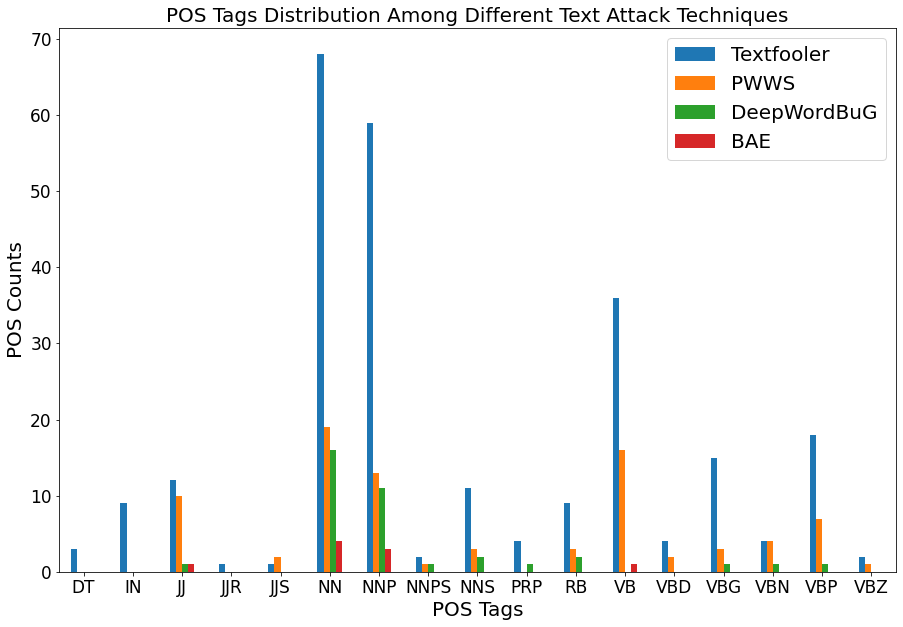

In [37]:
plotdata = pd.DataFrame({
    "Textfooler":count_pos_tags(pos_indexes, t_f_pos),
    "PWWS":count_pos_tags(pos_indexes, p_f_pos),
    "DeepWordBuG":count_pos_tags(pos_indexes, d_f_pos),
    "BAE":count_pos_tags(pos_indexes, b_f_pos)
    }, 
    index=pos_indexes
)
plotdata.plot(kind="bar", figsize=(15, 10), fontsize=17)
plt.xticks(rotation=0, horizontalalignment="center")
plt.title("POS Tags Distribution Among Different Text Attack Techniques", fontsize=20)
plt.legend(fontsize=20)
plt.xlabel("POS Tags", fontsize=20)
plt.ylabel("POS Counts", fontsize=20)

### POS Tags % Distribution Among Different Text Attack Techniques

[93, 130, 62, 2, 2, 164, 195, 4, 31, 68, 43, 87, 10, 24, 24, 50, 24]
[52, 74, 43, 0, 2, 98, 103, 4, 17, 34, 24, 56, 5, 10, 18, 27, 16]
[40, 52, 27, 0, 1, 70, 83, 3, 15, 19, 15, 40, 3, 6, 15, 15, 13]
[17, 22, 10, 0, 0, 24, 27, 2, 5, 9, 4, 9, 2, 2, 2, 7, 2]


Text(0, 0.5, 'POS Counts %')

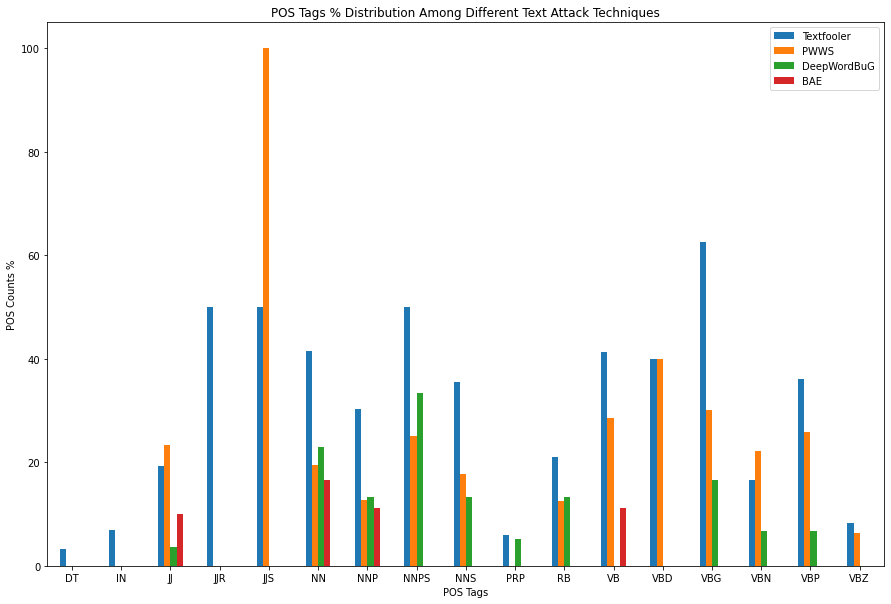

In [51]:
plotdata = pd.DataFrame({
    "Textfooler":pos_percentage(t_succeeded_examples,t_f_pos),
    "PWWS":pos_percentage(p_succeeded_examples,p_f_pos),
    "DeepWordBuG":pos_percentage(d_succeeded_examples, d_f_pos),
    "BAE":pos_percentage(b_succeeded_examples, b_f_pos)
    }, 
    index=pos_indexes
)
plotdata.plot(kind="bar", figsize=(15, 10))
plt.xticks(rotation=0, horizontalalignment="center")
plt.title("POS Tags % Distribution Among Different Text Attack Techniques", fontsize=20)
plt.xlabel("POS Tags", fontsize=20)
plt.ylabel("POS Counts %", fontsize=20)

### Succeed and Failed Text Attack Examples' Statistics

In [26]:
import textstat

In [94]:
def lecxicon_count(texts):
    lecxicon_count_list = []
    for text in texts:
        lecxicon_count_list.append(textstat.lexicon_count(text, removepunct=True))
    return lecxicon_count_list

def sentence_count(texts):
    sentence_count_list = []
    for text in texts: 
        sentence_count_list.append(textstat.sentence_count(text))
    return sentence_count_list

def polysyllab_count(texts):
    polysyllab_count_list = []
    for text in texts:
        polysyllab_count_list.append(textstat.polysyllabcount(text))
    return polysyllab_count_list

def monosyllab_count(texts):
    monosyllab_count_list = []
    for text in texts:
        monosyllab_count_list.append(textstat.monosyllabcount(text))
    return monosyllab_count_list

def flesch_reading_ease(texts):
    flesch_reading_ease_list = []
    for text in texts:
        flesch_reading_ease_list.append(textstat.flesch_reading_ease(text))
    return flesch_reading_ease_list

def gunning_fog(texts):
    gunning_fog_list = []
    for text in texts:
        gunning_fog_list.append(textstat.gunning_fog(text))
        
    return gunning_fog_list

def smog_index(texts):
    smog_index_list = []
    for text in texts:
        smog_index_list.append(textstat.smog_index(text))
        
    return smog_index_list

def difficult_words(texts):
    difficult_words_list = []
    for text in texts:
        difficult_words_list.append(textstat.difficult_words(text))
        
    return difficult_words_list

def mean_std_list(lst):
    return np.mean(lst), np.std(lst)

def print_stat_result(succeed, failed):
    print('lecxicon count mean and std of succeed examples', mean_std_list(lecxicon_count(succeed)))
    print('lecxicon count mean and std of failed examples', mean_std_list(lecxicon_count(failed)))
    print('*********************')
    print('sentence count mean and std of succeed examples', mean_std_list(sentence_count(succeed)))
    print('sentence count mean and std of failed examples', mean_std_list(sentence_count(failed)))
    print('*********************')
    print('polysyllab count mean and std of succeed examples', mean_std_list(polysyllab_count(succeed)))
    print('polysyllab count mean and std of failed examples', mean_std_list(polysyllab_count(failed)))
    print('*********************')
    print('monosyllab count mean and std of succeed examples', mean_std_list(monosyllab_count(succeed)))
    print('monosyllab count mean and std of failed examples', mean_std_list(monosyllab_count(failed)))
    print('*********************')
    print('flesch reading ease mean and std of succeed examples', mean_std_list(flesch_reading_ease(succeed)))
    print('flesch reading ease mean and std of failed examples', mean_std_list(flesch_reading_ease(failed)))
    print('*********************')
    print('gunning fog mean and std of succeed examples', mean_std_list(gunning_fog(succeed)))
    print('gunning fog mean and std of failed examples', mean_std_list(gunning_fog(failed)))
    print('*********************')
    print('smog index mean and std of succeed examples', mean_std_list(smog_index(succeed)))
    print('smog index ease and std of failed examples', mean_std_list(smog_index(failed)))
    print('*********************')
    print('difficult words mean and std of succeed examples', mean_std_list(difficult_words(succeed)))
    print('difficult words mean and std of failed examples', mean_std_list(difficult_words(failed)))
    print('*********************')
    

### Textfooler Statistic Results

In [95]:
print_stat_result(t_s_result,t_failed_examples)

lecxicon count mean and std of succeed examples (59.1, 42.24914200312239)
lecxicon count mean and std of failed examples (194.8125, 412.3907156371855)
*********************
sentence count mean and std of succeed examples (1.25, 0.4330127018922193)
sentence count mean and std of failed examples (2.5125, 3.065916461679933)
*********************
polysyllab count mean and std of succeed examples (6.0, 5.531726674375733)
polysyllab count mean and std of failed examples (26.7625, 80.37945069325865)
*********************
monosyllab count mean and std of succeed examples (40.75, 31.9372431496521)
monosyllab count mean and std of failed examples (132.3375, 259.16181932096015)
*********************
flesch reading ease mean and std of succeed examples (31.326, 39.294707709817615)
flesch reading ease mean and std of failed examples (5.147125000000001, 105.37630279377036)
*********************
gunning fog mean and std of succeed examples (23.033499999999997, 15.579750728108584)
gunning fog mean and

### DeepWordBug Statistic Results

In [96]:
print_stat_result(d_s_result,d_failed_examples)

lecxicon count mean and std of succeed examples (48.4, 28.810414783546587)
lecxicon count mean and std of failed examples (180.92222222222222, 391.1424073652794)
*********************
sentence count mean and std of succeed examples (1.5, 0.6708203932499369)
sentence count mean and std of failed examples (2.3444444444444446, 2.9256000756202365)
*********************
polysyllab count mean and std of succeed examples (6.1, 6.80367547726962)
polysyllab count mean and std of failed examples (24.444444444444443, 76.07643979155455)
*********************
monosyllab count mean and std of succeed examples (31.5, 18.76832437912346)
monosyllab count mean and std of failed examples (123.18888888888888, 246.04913215067182)
*********************
flesch reading ease mean and std of succeed examples (40.19799999999999, 28.500764130107108)
flesch reading ease mean and std of failed examples (7.0701111111111095, 100.67439172891811)
*********************
gunning fog mean and std of succeed examples (17.67

### PWWS Statistic Results

In [97]:
print_stat_result(p_s_result,p_failed_examples)

lecxicon count mean and std of succeed examples (45.666666666666664, 31.25522178594945)
lecxicon count mean and std of failed examples (189.2, 400.85713459154147)
*********************
sentence count mean and std of succeed examples (1.2, 0.4000000000000001)
sentence count mean and std of failed examples (2.447058823529412, 2.988235294117647)
*********************
polysyllab count mean and std of succeed examples (5.333333333333333, 6.0736223860962)
polysyllab count mean and std of failed examples (25.658823529411766, 78.10679761653293)
*********************
monosyllab count mean and std of succeed examples (31.066666666666666, 22.25748313613998)
monosyllab count mean and std of failed examples (128.65882352941176, 252.02556139926742)
*********************
flesch reading ease mean and std of succeed examples (42.302666666666674, 30.692917416817117)
flesch reading ease mean and std of failed examples (4.750000000000002, 102.78871070994016)
*********************
gunning fog mean and std 

### BAE Statistic Results

In [98]:
print_stat_result(b_s_result,b_failed_examples)

lecxicon count mean and std of succeed examples (33.4, 42.80467264213102)
lecxicon count mean and std of failed examples (174.73684210526315, 381.57052767480315)
*********************
sentence count mean and std of succeed examples (1.2, 0.4)
sentence count mean and std of failed examples (2.3157894736842106, 2.8553298561212888)
*********************
polysyllab count mean and std of succeed examples (6.2, 8.997777503361595)
polysyllab count mean and std of failed examples (23.473684210526315, 74.16593658536571)
*********************
monosyllab count mean and std of succeed examples (22.0, 28.52367437761131)
monosyllab count mean and std of failed examples (118.86315789473684, 240.15708063578177)
*********************
flesch reading ease mean and std of succeed examples (47.962, 25.877485503812)
flesch reading ease mean and std of failed examples (8.405052631578945, 98.3762508019051)
*********************
gunning fog mean and std of succeed examples (12.67, 7.865059440334828)
gunning fo

### Statistical Analysis of Failed Attack Examples

Text(0, 0.5, 'Mean Value')

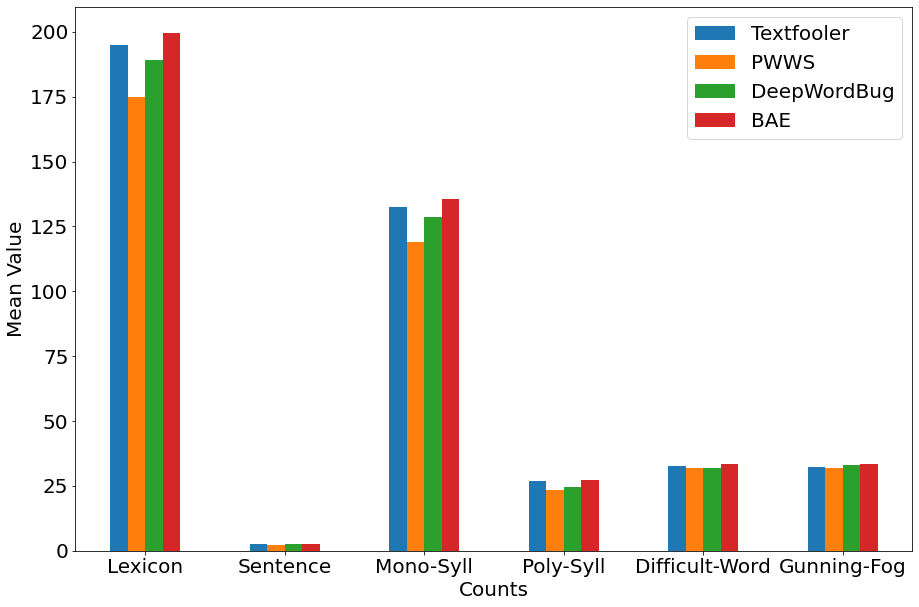

In [36]:
Textfooler = [194.82, 2.51, 132.33,26.76,32.75, 32.28]
PWWS = [174.73, 2.31, 118.86, 23.47, 31.94, 31.77]
DeepWordBug = [189.20,2.44,128.65, 24.44,31.94, 33.02]
BAE = [199.51,2.55,135.53,27.38,33.50,33.30]

index = ['Lexicon', 'Sentence', 'Mono-Syll','Poly-Syll','Difficult-Word','Gunning-Fog']
df = pd.DataFrame({'Textfooler': Textfooler,
                  'PWWS': PWWS,
               'DeepWordBug':DeepWordBug,
               'BAE':BAE},index=index)
#ax = df.plot.bar(rot=0)

df.plot(kind="bar", figsize=(15, 10), fontsize=20)
plt.xticks(rotation=0, horizontalalignment="center")
# plotdata.plot(kind="bar", figsize=(15, 10))
# plt.title("POS Tags Distribution Among Different Text Attack Techniques")
plt.legend(fontsize=20)
plt.xlabel("Counts", fontsize=20)
plt.ylabel("Mean Value", fontsize=20)

### Statistical Analysis of Successful Attack Examples

Text(0, 0.5, 'Mean Value')

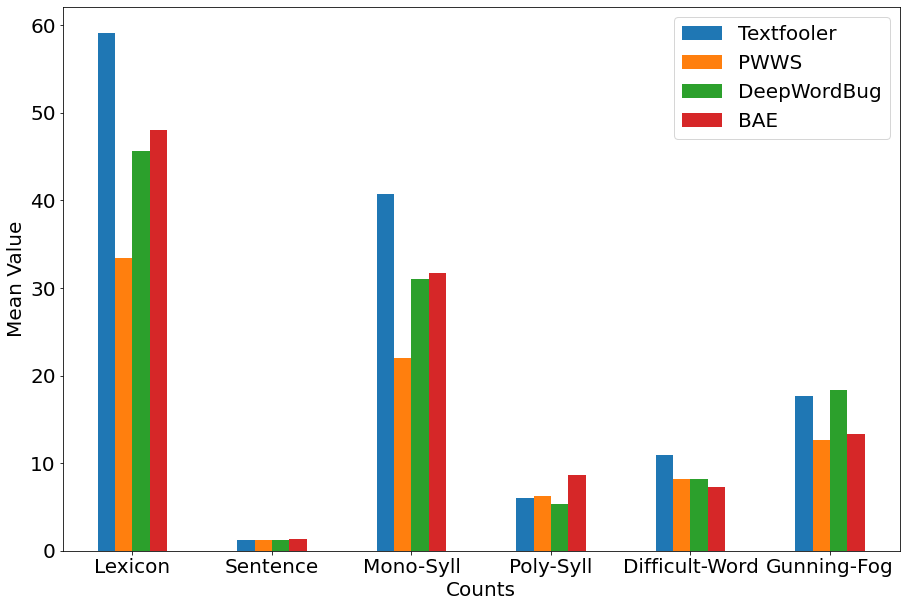

In [35]:
Textfooler = [59.1,1.25, 40.75, 6.00, 10.95, 17.67]
PWWS = [33.46,1.20,22.00,6.20,8.20,12.67]
DeepWordBug = [45.60,1.20,31.06, 5.30,8.20, 18.35]
BAE = [48.00,1.30,31.66,8.60,7.30,13.30]

index = ['Lexicon', 'Sentence', 'Mono-Syll','Poly-Syll','Difficult-Word','Gunning-Fog']
df = pd.DataFrame({'Textfooler': Textfooler,
                  'PWWS': PWWS,
               'DeepWordBug':DeepWordBug,
               'BAE':BAE},index=index)
#ax = df.plot.bar(rot=0)

df.plot(kind="bar", figsize=(15, 10), fontsize=20)
plt.xticks(rotation=0, horizontalalignment="center")
# plotdata.plot(kind="bar", figsize=(15, 10))
# plt.title("POS Tags Distribution Among Different Text Attack Techniques")
plt.legend(fontsize=20)
plt.xlabel("Counts", fontsize=20)
plt.ylabel("Mean Value", fontsize=20)